In [25]:
#ノック２１

import pandas as pd
uselog = pd.read_csv('data/use_log.csv')
print(len(uselog))
uselog.head()

customer = pd.read_csv('data/customer_master.csv')
print(len(customer))
customer.head()

class_master = pd.read_csv('data/class_master.csv')
print(len(class_master))
class_master.head()

campaign_master = pd.read_csv('data/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

197428
4192
3
3


campaign_id campaign_name
0         CA1            通常
1         CA2         入会費半額
2         CA3         入会費無料

In [26]:
#ノック２２

customer_join = pd.merge(customer, class_master, on="class", how="left")
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left")
customer_join.head()

customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

In [27]:
#ノック２３

customer_join.groupby("class_name").count()["customer_id"]

customer_join.groupby("campaign_name").count()["customer_id"]

customer_join.groupby("gender").count()["customer_id"]

customer_join.groupby("is_deleted").count()["customer_id"]

customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


In [28]:
#ノック２４

customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331"))|(customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

customer_newer.groupby("class_name").count()["customer_id"]

customer_newer.groupby("campaign_name").count()["customer_id"]

customer_newer.groupby("gender").count()["customer_id"]

2953


gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [29]:
#ノック２５

uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月", "customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"},inplace=True)
del uselog_months["usedate"]
uselog_months.head()

uselog_customer = uselog_months.groupby("customer_id").agg(["mean","median","max", "min"])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

customer_id      mean  median  max  min
0    AS002855  4.500000     5.0    7    2
1    AS008805  4.000000     4.0    8    1
2    AS009013  2.000000     2.0    2    2
3    AS009373  5.083333     5.0    7    3
4    AS015233  7.545455     7.0   11    4

In [30]:
#ノック２６

uselog["weekday"] = uselog["usedate"].dt.weekday
uselog_weekday = uselog.groupby(["customer_id", "年月","weekday"], as_index = False).count()[["customer_id", "年月", "weekday", "log_id"]]
uselog_weekday.rename(columns={"log_id":"count"}, inplace=True)
uselog_weekday.head()

uselog_weekday = uselog_weekday.groupby("customer_id", as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"]<4, 1)
uselog_weekday.head()

customer_id  count  routine_flg
0    AS002855      5            1
1    AS008805      4            1
2    AS009013      2            0
3    AS009373      5            1
4    AS015233      5            1

In [31]:
#ノック２７
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()
customer_join.isnull()

customer_id   name  class  gender  start_date  end_date  campaign_id  \
0           False  False  False   False       False      True        False   
1           False  False  False   False       False      True        False   
2           False  False  False   False       False      True        False   
3           False  False  False   False       False      True        False   
4           False  False  False   False       False      True        False   
...           ...    ...    ...     ...         ...       ...          ...   
4187        False  False  False   False       False      True        False   
4188        False  False  False   False       False      True        False   
4189        False  False  False   False       False      True        False   
4190        False  False  False   False       False      True        False   
4191        False  False  False   False       False      True        False   

      is_deleted  class_name  price  campaign_name   mean  median    max  \
0          False       False  False          False  False   False  False   
1          False       False  False          False  False   False  False   
2          False       False  False          False  False   False  False   
3          False       False  False          False  False   False  False   
4          False       False  False          False  False   False  False   
...          ...         ...    ...            ...    ...     ...    ...   
4187       False       False  False          False  False   False  False   
4188       False       False  False          False  False   False  False   
4189       False       False  False          False  False   False  False   
4190       False       False  False          False  False   False  False   
4191       False       False  False          False  False   False  False   

        min  routine_flg  
0     False        False  
1     False        False  
2     False        False  
3     False        False  
4     False        False  
...     ...          ...  
4187  False        False  
4188  False        False  
4189  False        False  
4190  False        False  
4191  False        False  

[4192 rows x 16 columns]

In [32]:
#ノック２８

from dateutil.relativedelta import relativedelta
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months
customer_join.head()

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


customer_id   name class gender start_date end_date campaign_id  is_deleted  \
0    OA832399   XXXX   C01      F 2015-05-01      NaT         CA1           0   
1    PL270116  XXXXX   C01      M 2015-05-01      NaT         CA1           0   
2    OA974876  XXXXX   C01      M 2015-05-01      NaT         CA1           0   
3    HD024127  XXXXX   C01      F 2015-05-01      NaT         CA1           0   
4    HD661448  XXXXX   C03      F 2015-05-01      NaT         CA1           0   

  class_name  price campaign_name      mean  median  max  min  routine_flg  \
0     オールタイム  10500            通常  4.833333     5.0    8    2            1   
1     オールタイム  10500            通常  5.083333     5.0    7    3            1   
2     オールタイム  10500            通常  4.583333     5.0    6    3            1   
3     オールタイム  10500            通常  4.833333     4.5    7    2            1   
4        ナイト   6000            通常  3.916667     4.0    6    1            1   

   calc_date  membership_period  
0 2019-04-30                 47  
1 2019-04-30                 47  
2 2019-04-30                 47  
3 2019-04-30                 47  
4 2019-04-30                 47

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

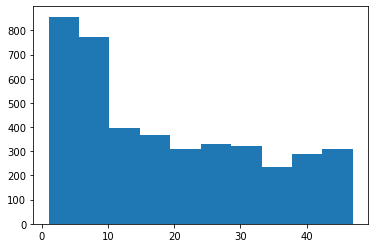

In [33]:
#ノック２９

customer_join[["mean", "median", "max", "min"]].describe()
customer_join.groupby("routine_flg").count()["customer_id"]

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

In [34]:
#ノック３０
customer_end = customer_join.loc[customer_join["is_deleted"]==1]
customer_end.describe()

customer_stay = customer_join.loc[customer_join["is_deleted"]==0]
customer_stay.describe()

customer_join.to_csv("customer_join.csv", index=False)

is_deleted         price         mean       median          max  \
count      2842.0   2842.000000  2842.000000  2842.000000  2842.000000   
mean          0.0   8542.927516     6.030288     6.024279     8.471147   
std           0.0   1977.189779     1.553587     1.599765     1.571048   
min           0.0   6000.000000     3.166667     3.000000     5.000000   
25%           0.0   6000.000000     4.833333     5.000000     7.000000   
50%           0.0   7500.000000     5.583333     5.500000     8.000000   
75%           0.0  10500.000000     7.178030     7.000000    10.000000   
max           0.0  10500.000000    12.000000    12.000000    14.000000   

               min  routine_flg  membership_period  
count  2842.000000  2842.000000        2842.000000  
mean      3.620690     0.984166          23.970443  
std       2.030488     0.124855          13.746761  
min       1.000000     0.000000           1.000000  
25%       2.000000     1.000000          12.000000  
50%       3.000000     1.000000          24.000000  
75%       5.000000     1.000000          35.000000  
max      12.000000     1.000000          47.000000